# TDC Calibration

## define the diagnostic

In [1]:
from measurement import get_DYG14, set_camera, set_background

save_image_location = "/home/awa/awa_data/12-07_6DReconstruction/tdc_calibration"
image_diagnostic = get_DYG14()
image_diagnostic.save_image_location = save_image_location


In [2]:
set_background(image_diagnostic)

"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Dec 05 2023 15:19:53.935342306
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Dec 05 2023 15:19:53.935271537
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize0_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064errlog: 4 messages were discarded
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp lin

array([[ 2124.8,  3456. ,  2688. , ...,  2009.6,  1984. ,  2060.8],
       [ 2086.4,  1990.4,  2406.4, ...,  5606.4,  8630.4,  1984. ],
       [ 7782.4,  2748.8,  1971.2, ..., 17312. ,  3062.4,  5427.2],
       ...,
       [ 2342.4,  2000. ,  2076.8, ...,  2044.8,  2035.2,  2585.6],
       [ 2163.2,  1987.2,  2025.6, ...,  2169.6,  5046.4,  1984. ],
       [ 1971.2,  2969.6,  5872. , ...,  2012.8,  2547.2,  2636.8]])

5.537276786832282e-10
charge error 5.5e-10 outside atol 1e-10
1.1678815757844844e-10
charge error 1.2e-10 outside atol 1e-10
4.1984200798802815e-10
charge error 4.2e-10 outside atol 1e-10
1.6881718254350148e-10
charge error 1.7e-10 outside atol 1e-10
1.461096454066697e-10
charge error 1.5e-10 outside atol 1e-10
4.2490557139271433e-10
charge error 4.2e-10 outside atol 1e-10
1.4013644877283186e-10
charge error 1.4e-10 outside atol 1e-10
4.4943830570140806e-11
displaying image
fitting image


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': nan,
 'total_intensity': 19840584.0,
 'log10_total_intensity': 7.297554451298234,
 'AWAVXI11ICT:Ch4': 1.2449438305701408e-09}

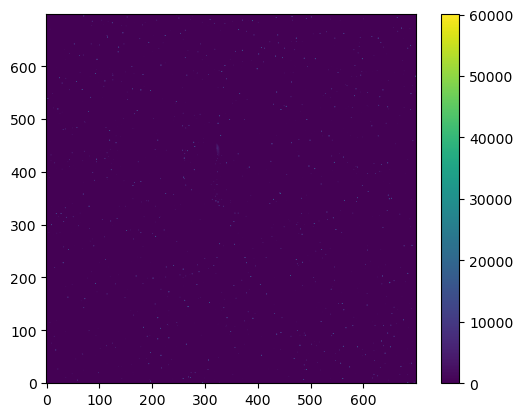

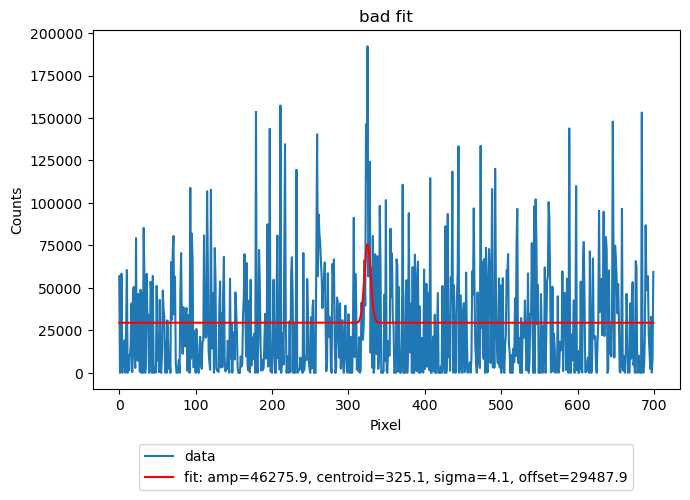

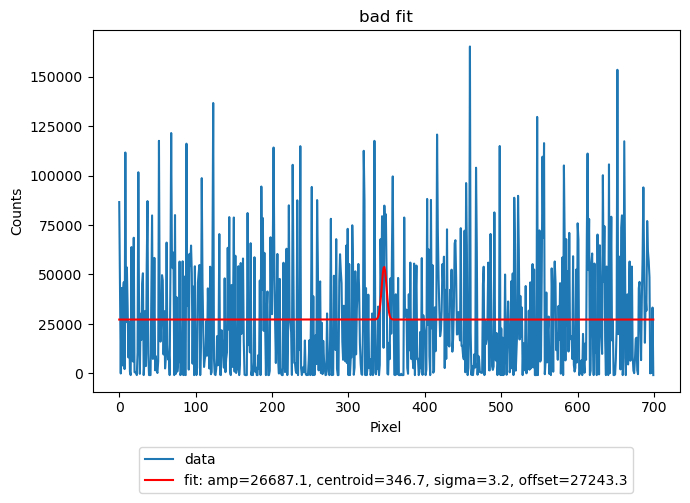

In [3]:
image_diagnostic.test_measurement()

### Define the evaluator

In [4]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

def evaluate_function(inputs: dict) -> dict:
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)
        print(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(5)

    results = image_diagnostic.measure_beamsize(5, **inputs)

    # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
    results = results

    # add total beam size
    results["total_size"] = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
    return results

evaluator = Evaluator(function=evaluate_function)

### Define VOCS
Here we define the names and ranges of input parameters, the names and settings of
objectives, and the names and settings of constraints. Note that the keys here should
 be referenced in the evaluate function above.

In [5]:
from xopt import VOCS

TDC_PHASE_PV = "AWALLRF:K5:SetPhase"

# define control PVs and ranges here
vocs = VOCS(
    variables = {
        TDC_PHASE_PV: [130, 170], # Quad 4:9
    },
    objectives = {"total_size":"MINIMIZE"},
)

### Define the Generator (NOT USED HERE)

In [6]:
from xopt.generators import get_generator
generator = get_generator("random")(vocs=vocs)

###  Combine into Xopt object

In [7]:
from xopt import Xopt
dump_filename = "/home/awa/awa_data/12-05_6DReconstruction/tdc_calibration/tdc_calibration.yml"
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, dump_file=dump_filename)

## Introspection
Objects in Xopt can be printed to a string or dumped to a text file for easy
introspection of attributes and current configuration.

In [8]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 2.1.0+27.g53bd9d64.dirty
Data size: 0
Config as YAML:
dump_file: /home/awa/awa_data/12-05_6DReconstruction/tdc_calibration/tdc_calibration.yml
evaluator:
  function: __main__.evaluate_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  name: random
  supports_batch_generation: true
  supports_multi_objective: true
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives:
    total_size: MINIMIZE
  observables: []
  variables:
    AWALLRF:K5:SetPhase:
    - 130.0
    - 170.0


### Do scan

In [9]:
# examine the data stored in Xopt
tdc_phase_values = np.linspace(150,160,10)
X.evaluate_data({TDC_PHASE_PV: tdc_phase_values})

AWALLRF:K5:SetPhase 150.0
1.261137920296409e-10
charge error 1.3e-10 outside atol 1e-10
9.088892092499496e-11
fitting image
1.444529882150637e-10
charge error 1.4e-10 outside atol 1e-10
3.248042916806174e-10
charge error 3.2e-10 outside atol 1e-10
1.9906177759648198e-10
charge error 2e-10 outside atol 1e-10
2.6475459067288115e-10
charge error 2.6e-10 outside atol 1e-10
2.446623739074946e-10
charge error 2.4e-10 outside atol 1e-10
8.185237663884871e-11
fitting image
5.4758053851439914e-11
fitting image
2.860220805390803e-10
charge error 2.9e-10 outside atol 1e-10
1.6488969902429243e-10
charge error 1.6e-10 outside atol 1e-10
3.0347826330750967e-10
charge error 3e-10 outside atol 1e-10
2.6179164162948216e-10
charge error 2.6e-10 outside atol 1e-10
1.7662485103488303e-10
charge error 1.8e-10 outside atol 1e-10
2.258979340129132e-11
fitting image
3.4705252668611207e-10
charge error 3.5e-10 outside atol 1e-10
1.464978007373037e-10
charge error 1.5e-10 outside atol 1e-10
8.159750898556977e-1

,AWALLRF:K5:SetPhase,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
0,150.000000,325.897266,181.826218,4.70962,27.66173,-95.947872,31536131.2,7.498808,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,28.05979,26.565845,False
1,150.000000,323.832781,191.283468,5.248018,26.050978,-109.451255,36417148.8,7.561306,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,26.574332,26.565845,False
2,150.000000,324.783155,193.457369,5.727509,30.14706,-99.403294,35039201.6,7.544554,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,30.686309,26.565845,False
3,150.000000,325.492581,207.609898,5.001117,21.820188,-138.427316,29920358.4,7.475967,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,22.385973,26.565845,False
4,150.000000,324.869358,200.051333,5.069611,27.071373,-115.343852,32934235.2,7.517648,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,27.541972,26.565845,False
5,151.111111,323.909481,234.92249,4.961035,29.77649,-141.526857,31716736.0,7.501288,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,30.186938,29.655039,False
6,151.111111,324.351739,256.157121,4.747436,31.244119,-158.230017,32740574.4,7.515086,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,31.602739,29.655039,False
7,151.111111,324.461784,236.288481,4.738529,28.105669,-148.020639,33336124.8,7.522915,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,28.502321,29.655039,False
8,151.111111,324.808092,227.222556,5.19075,25.239284,-147.362148,30370835.2,7.482457,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,25.767525,29.655039,False
9,151.111111,324.985607,239.974164,4.895717,28.537104,-150.375087,31399120.0,7.496917,0.0,/home/awa/awa_data/12-05_6DReconstruction/beam...,28.954004,29.655039,False


<Axes: xlabel='AWALLRF:K5:SetPhase'>

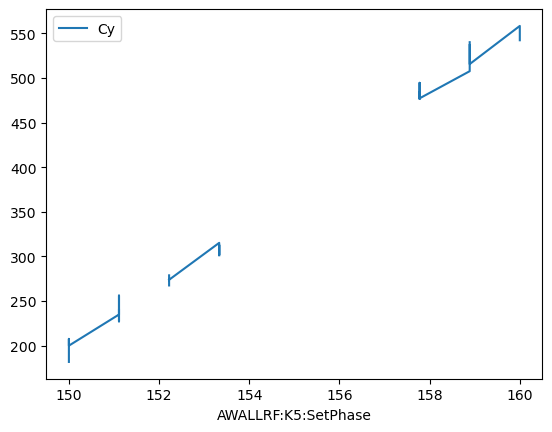

In [10]:
# visualize result
X.data.plot(x=X.vocs.variable_names[0],y="Cy")

### Polynomial fit for TDC calibration
do a linear fit of px centroid to TDC amplitude

TDC deflection to screen from zero crossing
- $ y_f = \kappa L z_0 $
- $z = \frac{\phi \lambda}{2\pi}$
- $\kappa = \frac{2\pi}{L\lambda}\frac{\Delta y}{\Delta \phi}$
- To double check $\kappa = \frac{eV}{pc}\frac{2\pi}{\lambda}$

In [18]:

import numpy as np
print(
    X.data[TDC_PHASE_PV].to_numpy(dtype="float"), 
    X.data["Cy"].to_numpy(dtype="float")
)
p = np.polyfit(
    X.data[TDC_PHASE_PV].to_numpy(dtype="float"), 
    X.data["Cy"].to_numpy(dtype="float"), 
    1
)
print(p)

slope = p[0]
meters_per_pixel = 1158 / 50e-3  # m / px
rad_per_pv = 180 / 3.14 # rad

slope_m_per_rad = slope * meters_per_pixel / rad_per_pv # m / rad
tdc_to_screen_drift = 1.521 # m
tdc_wavelength = 1.3e9 / 3e8 # m

kappa = (2*np.pi) / (tdc_wavelength * tdc_to_screen_drift) * slope_m_per_rad
print(kappa) # m^-1


[150.         150.         150.         150.         150.
 151.11111111 151.11111111 151.11111111 151.11111111 151.11111111
 152.22222222 152.22222222 152.22222222 152.22222222 152.22222222
 153.33333333 153.33333333 153.33333333 153.33333333 153.33333333
 154.44444444 154.44444444 154.44444444 154.44444444 154.44444444
 155.55555556 155.55555556 155.55555556 155.55555556 155.55555556
 156.66666667 156.66666667 156.66666667 156.66666667 156.66666667
 157.77777778 157.77777778 157.77777778 157.77777778 157.77777778
 158.88888889 158.88888889 158.88888889 158.88888889 158.88888889
 160.         160.         160.         160.         160.        ] [181.82621825 191.28346761 193.45736943 207.60989796 200.05133257
 234.92249007 256.15712131 236.28848135 227.22255571 239.97416427
          nan 267.50561671 278.81863254          nan 273.84287762
 315.21679675 301.63926731 312.81100397 301.29506384          nan
          nan          nan          nan          nan          nan
          nan    

LinAlgError: SVD did not converge in Linear Least Squares

CA.Client.Exception...............................................
    Context: "awa5:5064"
    Source File: ../cac.cpp line 1237
    Current Time: Tue Dec 05 2023 15:31:37.890129338
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Dec 05 2023 15:32:10.746071899
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize0_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Dec 05 2023 15:32:10.746203969
..................................................................
CA.Client.Exception...............................................
    Context: "Ch

In [ ]:
# calc from approx energy TDC voltage
tdc_voltage = 1
beam_momentum = 48e6
print((tdc_voltage / beam_momentum) * (2*np.pi / tdc_wavelength) )